In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv('combined_data.csv')
df

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

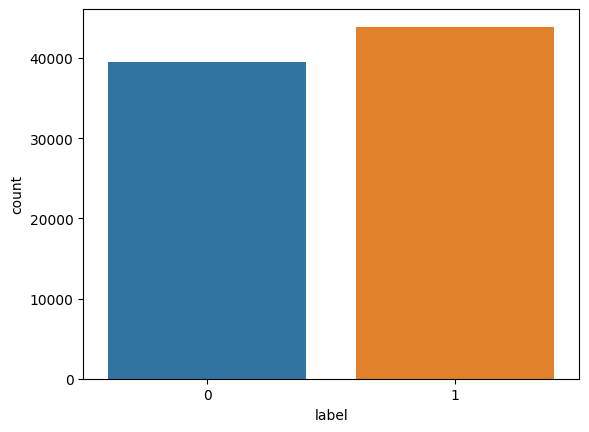

In [ ]:
sns.countplot(x = 'label', data = df)
plt.show()

In [ ]:
labels = {0 : "Not Spam", 1 : "Spam"}
label_counts = df['label'].value_counts()
print(label_counts)

1    43910
0    39538
Name: label, dtype: int64


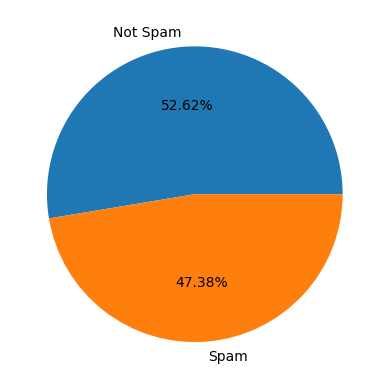

In [ ]:
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()

In [ ]:
df.groupby(df['label']).describe()


text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538   computer connection from cnn com wednesday es...    1
1      43910  43910  ounce feather bowl hummingbird opec moment ala...    1

In [ ]:
df.isna().sum()


label    0
text     0
dtype: int64

In [ ]:
print(f"Number of duplicated urls : {np.sum(df.duplicated())}")

df.drop_duplicates(inplace = True)

print(f"Number of duplicated urls (after dropping duplicates) : {np.sum(df.duplicated())}")

Number of duplicated urls : 0
Number of duplicated urls (after dropping duplicates) : 0


In [ ]:
df.shape

(83448, 2)

In [ ]:
train_texts = df['text'].tolist()
train_labels = df['label'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts,train_labels,test_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)
train_texts, val_texts,train_labels,val_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)

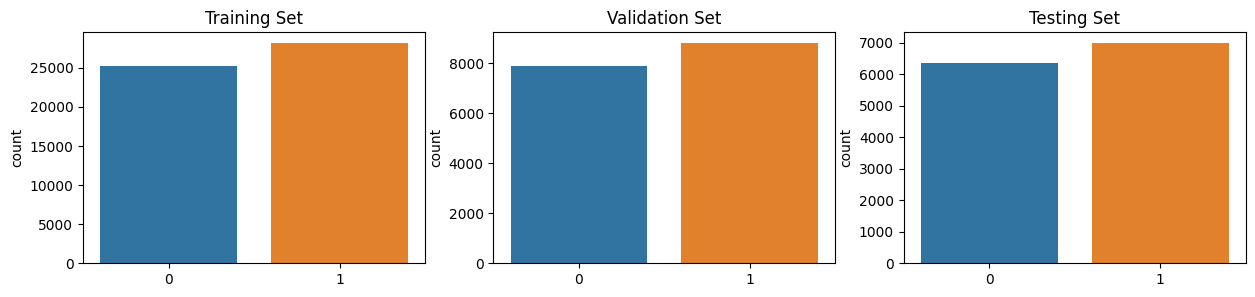

In [ ]:
# Checking whether the labels are distributed uniformely

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.countplot(x=train_labels)

plt.subplot(1, 3, 2)
plt.title("Validation Set")
sns.countplot(x=test_labels)

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.countplot(x=val_labels)

plt.show()

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

(…).co/roberta-base/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(…)co/roberta-base/resolve/main/config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)
val_dataset = SpamDataset(val_encodings,val_labels)


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.1 MB/s eta 0:00:00


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size = 16,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = 16,shuffle=True)

optim = torch.optim.AdamW(model.parameters(), lr=1e-6)

training_losses = []
validation_losses = []
testing_losses = []
testing_predictions = []
testing_labels = []

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(2):
  #Training
  model.train()
  for step,batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs[0]
      loss.backward()
      optim.step()

      training_losses.append(loss.item())

      if step % 150 == 0:
        print(f'Training - Epoch: {epoch}, Step: {step}, Loss: {loss.item()}')


  # Validation
  model.eval()
  with torch.no_grad():
    val_loss = 0.0
    val_steps = 0
    for val_batch in val_loader:
      input_ids = val_batch['input_ids'].to(device)
      attention_mask = val_batch['attention_mask'].to(device)
      labels = val_batch['labels'].to(device)
      val_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      val_loss += val_outputs[0].item()
      val_steps += 1
      average_val_loss = val_loss / val_steps
      validation_losses.append(average_val_loss)

      if val_steps % 50 == 0:
        print(f'Validation - Epoch: {epoch}, Average Loss: {average_val_loss}')



Training - Epoch: 0, Step: 0, Loss: 0.6924149394035339
Training - Epoch: 0, Step: 150, Loss: 0.4077147841453552
Training - Epoch: 0, Step: 300, Loss: 0.10927484929561615
Training - Epoch: 0, Step: 450, Loss: 0.02301008254289627
Training - Epoch: 0, Step: 600, Loss: 0.04850035905838013
Training - Epoch: 0, Step: 750, Loss: 0.09770059585571289
Training - Epoch: 0, Step: 900, Loss: 0.05121306702494621
Training - Epoch: 0, Step: 1050, Loss: 0.01894889771938324
Training - Epoch: 0, Step: 1200, Loss: 0.09194103628396988
Training - Epoch: 0, Step: 1350, Loss: 0.014320867136120796
Training - Epoch: 0, Step: 1500, Loss: 0.037150461226701736
Training - Epoch: 0, Step: 1650, Loss: 0.06413258612155914
Validation - Epoch: 0, Average Loss: 0.028592206574976443
Validation - Epoch: 0, Average Loss: 0.043857034558895974
Validation - Epoch: 0, Average Loss: 0.04399402120150626
Validation - Epoch: 0, Average Loss: 0.04666812073905021
Validation - Epoch: 0, Average Loss: 0.04557950755674392
Validation - E

In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_steps = 0

    for test_batch in test_loader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)

        test_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += test_outputs[0].item()
        test_steps += 1

        average_test_loss = test_loss / test_steps
        testing_losses.append(average_test_loss)

        if test_steps % 100 == 0:
          print(f'Test - Average Loss: {average_test_loss}')

        # Collecting predictions and labels for further analysis
        testing_predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())
        testing_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(testing_labels, testing_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test - Average Loss: 0.03629303125431761
Test - Average Loss: 0.03568824461661279
Test - Average Loss: 0.03789974830617818
Test - Average Loss: 0.035919274351326747
Test - Average Loss: 0.038970582195091995
Test - Average Loss: 0.04020959528783957
Test - Average Loss: 0.040207617625960014
Test - Average Loss: 0.04281557868031086
Test - Average Loss: 0.04264186843841647
Test - Average Loss: 0.042070280362386255
Test Accuracy: 0.986998202516477


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(testing_labels, testing_predictions, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Support: {support}')

Precision: 0.9856188427131695
Recall: 0.9897657493745736
F1-score: 0.9876879432624114
Support: None


In [ ]:
print("Quartiles for the training loss values : ")
print(np.quantile(training_losses, [0,0.25,0.5,0.75,1]))

print("Quartiles for the validation loss values : ")
print(np.quantile(validation_losses, [0,0.25,0.5,0.75,1]))

print("Quartiles for the testing loss values : ")
print(np.quantile(testing_losses, [0,0.25,0.5,0.75,1]))

Quartiles for the training loss values : 
[0.00250222 0.01573292 0.04062751 0.10868565 0.71150446]
Quartiles for the validation loss values : 
[0.00258737 0.03602448 0.04306253 0.05384412 0.10216283]
Quartiles for the testing loss values : 
[0.03296326 0.03683747 0.03996262 0.04197009 0.14991342]


In [ ]:
text = "Hello freind, you were just awarded for a free vacation on turkey"
ids = tokenizer.encode(text,add_special_tokens = True, return_tensors = "pt").to(device)

with torch.no_grad():
  output = model(ids)

logits = output.logits
predicted_class = torch.argmax(logits,dim=1).item()

print(f"Predicted class : {predicted_class}")

Predicted class : 1


In [ ]:
model.save_pretrained('spam-detection-model')

In [ ]:
PATH = "roberta-base-spam-detection.pt"

torch.save(model.state_dict(), PATH)

In [ ]:
PATH = "roberta-base-spam-detection.pth"

torch.save(model.state_dict(), PATH)

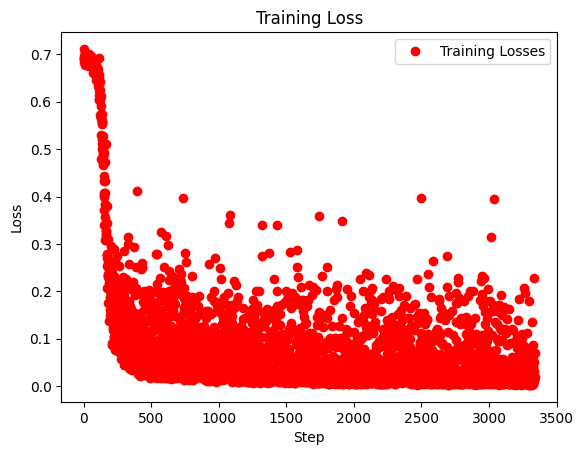

In [ ]:
train_steps = range(1, len(training_losses) + 1)

plt.plot(train_steps, training_losses, 'ro', label='Training Losses')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

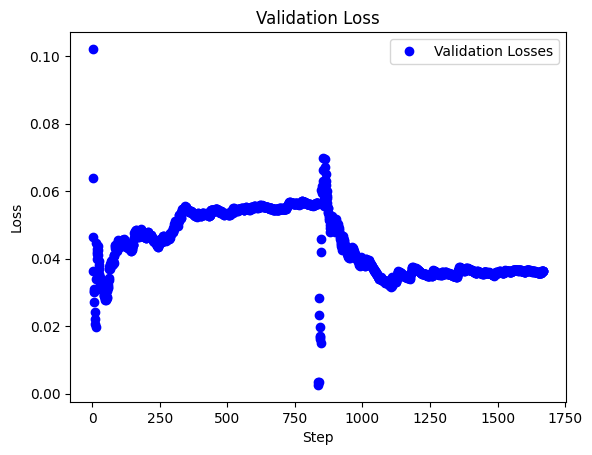

In [ ]:
val_steps = range(1, len(validation_losses) + 1)

plt.plot(val_steps, validation_losses, 'bo', label='Validation Losses')
plt.title('Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

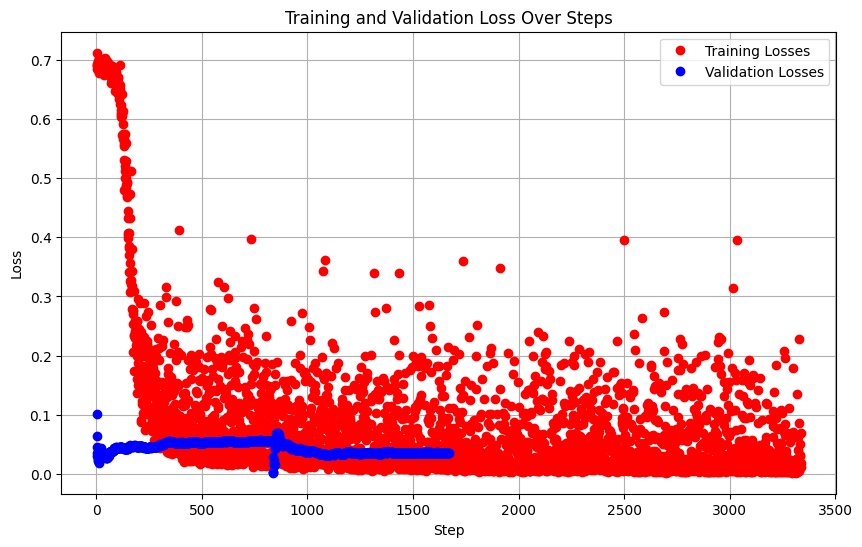

In [ ]:
train_steps = range(1, len(training_losses) + 1)
val_steps = range(1,len(validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, training_losses, 'ro', label='Training Losses')
plt.plot(val_steps, validation_losses, 'bo', label='Validation Losses')
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

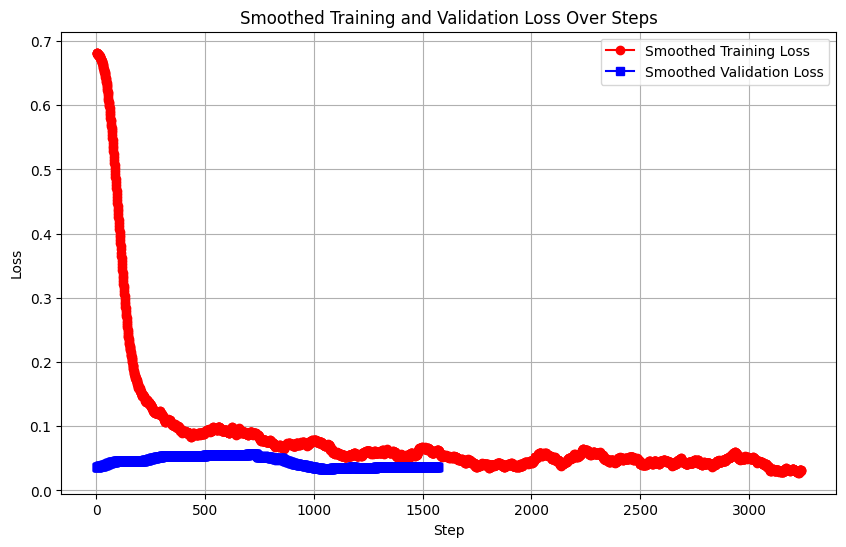

In [ ]:
smoothed_training_losses = np.convolve(training_losses, np.ones(100) / 100, mode='valid')
smoothed_validation_losses = np.convolve(validation_losses, np.ones(100) / 100, mode='valid')

train_steps = range(1,len(smoothed_training_losses) + 1)
val_steps = range(1,len(smoothed_validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, smoothed_training_losses, label='Smoothed Training Loss', marker='o',color='red')
plt.plot(val_steps, smoothed_validation_losses, label='Smoothed Validation Loss', marker='s',color='blue')
plt.title('Smoothed Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

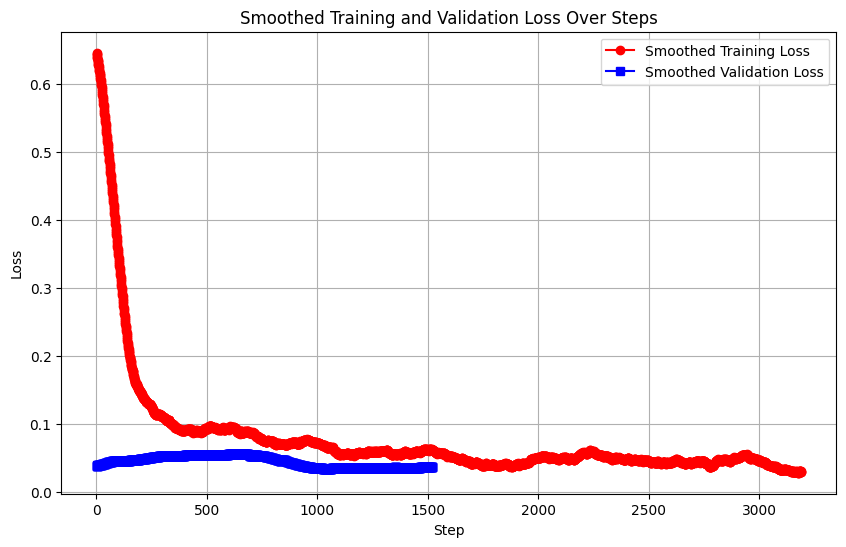

In [ ]:
smoothed_training_losses = np.convolve(training_losses, np.ones(150) / 150, mode='valid')
smoothed_validation_losses = np.convolve(validation_losses, np.ones(150) / 150, mode='valid')

train_steps = range(1,len(smoothed_training_losses) + 1)
val_steps = range(1,len(smoothed_validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, smoothed_training_losses, label='Smoothed Training Loss', marker='o',color='red')
plt.plot(val_steps, smoothed_validation_losses, label='Smoothed Validation Loss', marker='s',color='blue')
plt.title('Smoothed Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

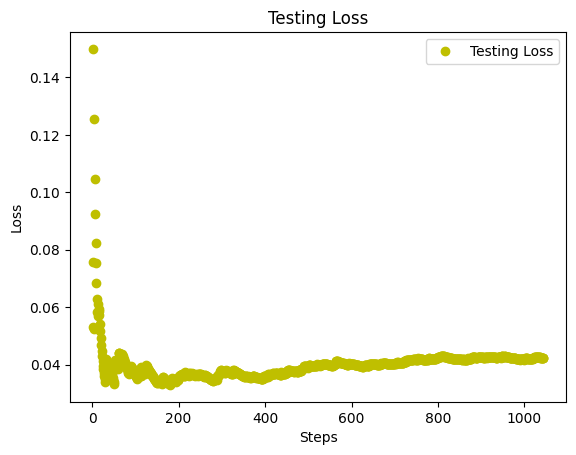

In [ ]:
test_steps = range(1, len(testing_losses) + 1)

plt.plot(test_steps, testing_losses, 'yo', label='Testing Loss')
plt.title('Testing Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

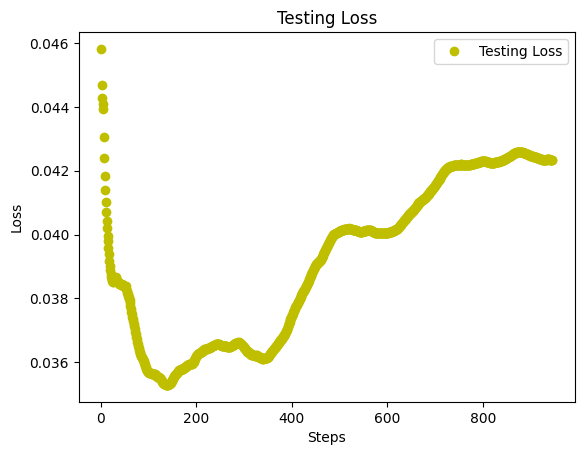

In [ ]:
smoothed_testing_losses = np.convolve(testing_losses, np.ones(100) / 100, mode='valid')

test_steps = range(1, len(smoothed_testing_losses) + 1)

plt.plot(test_steps, smoothed_testing_losses, 'yo', label='Testing Loss')
plt.title('Testing Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

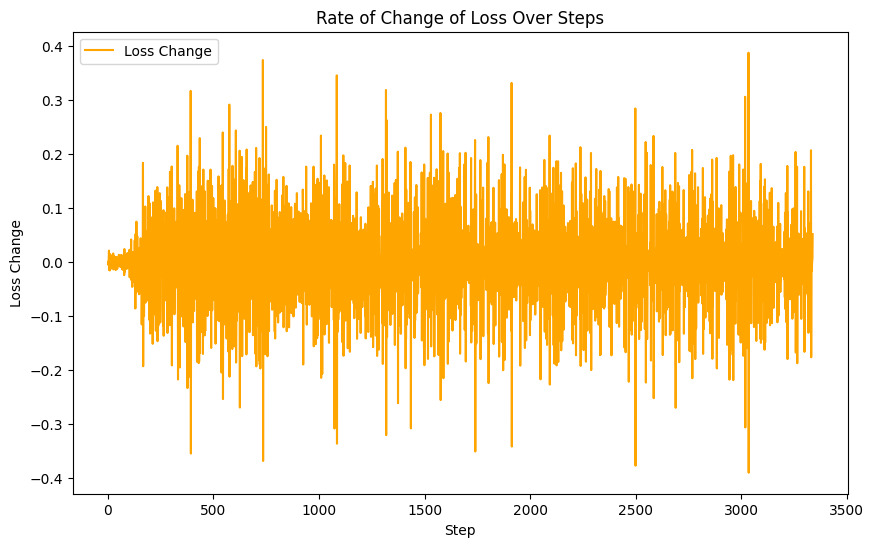

In [ ]:
loss_change = [loss - training_losses[i - 1] if i > 0 else 0 for i, loss in enumerate(training_losses)]
train_steps = range(1,len(training_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, loss_change, label='Loss Change', color='orange')
plt.title('Rate of Change of Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss Change')
plt.legend()
plt.show()

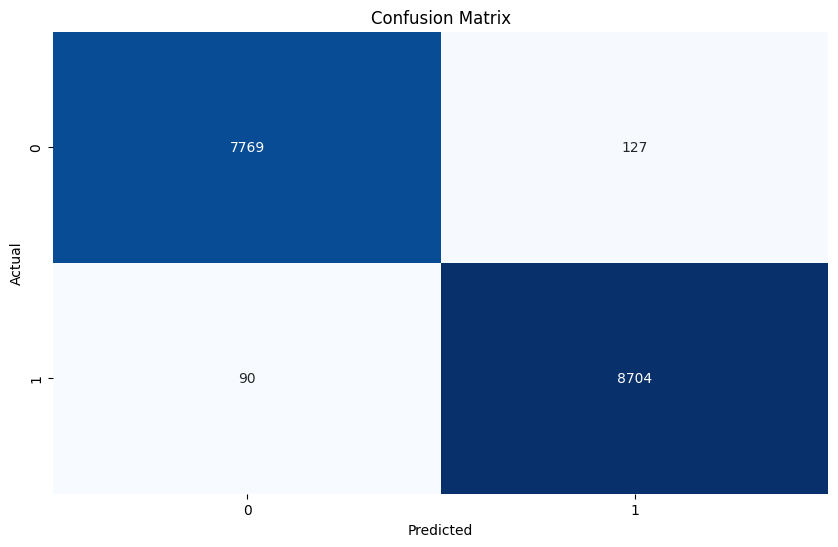

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_labels, testing_predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

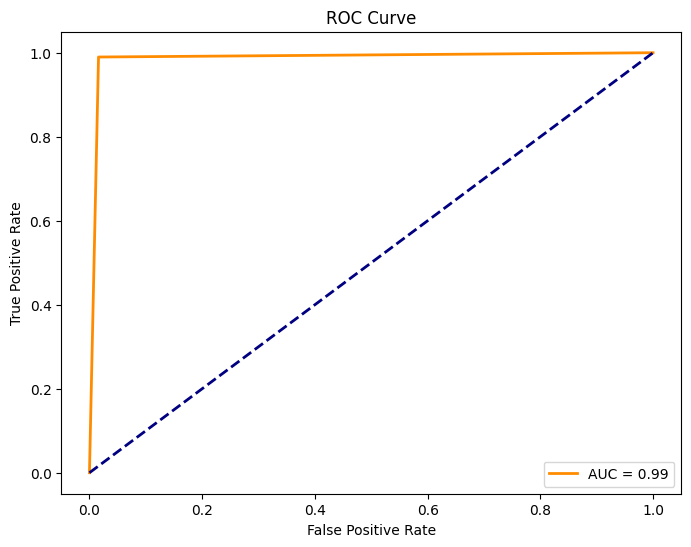

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(testing_labels, testing_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install jiwer
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 47.6 MB/s eta 0:00:00


In [ ]:
import math
from jiwer import wer
from nltk.translate.bleu_score import corpus_bleu

testing_labels_str = [str(label) for label in testing_labels]
testing_predictions_str = [str(prediction) for prediction in testing_predictions]


wer_score = wer(testing_labels_str, testing_predictions_str)
print(f'Test Word Error Rate: {wer_score}')

bleu_score = corpus_bleu([[ref] for ref in testing_labels_str], [hyp for hyp in testing_predictions_str])
print(f'Test Bleu Score: {bleu_score}')

bleu_score_nonlog = math.exp(bleu_score)

print(f'Test Bleu Score (non-log scale): {bleu_score_nonlog}')

Test Word Error Rate: 0.013001797483523068
Test Bleu Score: 1.8158811232105174e-231
Test Bleu Score (non-log scale): 1.0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

#This Place is for testing the model performance before training

In [ ]:
model_naive = RobertaForSequenceClassification.from_pretrained('roberta-base')
model_naive.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
model_naive.eval()
with torch.no_grad():
    test_loss = 0.0
    test_steps = 0

    for test_batch in test_loader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)

        test_outputs = model_naive(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += test_outputs[0].item()
        test_steps += 1

        average_test_loss = test_loss / test_steps
        testing_losses.append(average_test_loss)

        if test_steps % 50 == 0:
          print(f'Test - Average Loss: {average_test_loss}')

        # Collecting predictions and labels for further analysis
        testing_predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())
        testing_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(testing_labels, testing_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test - Average Loss: 0.6981444501876831
Test - Average Loss: 0.6945787131786346
Test - Average Loss: 0.6937971683343251
Test - Average Loss: 0.6936296704411506
Test - Average Loss: 0.6931759469509124
Test - Average Loss: 0.6921016850074132
Test - Average Loss: 0.6924856451579503
Test - Average Loss: 0.6921850027143955
Test - Average Loss: 0.69226580063502
Test - Average Loss: 0.6925935735702514
Test - Average Loss: 0.6921312315897508
Test - Average Loss: 0.6918845108151436
Test - Average Loss: 0.6918796635591067
Test - Average Loss: 0.6917342793090003
Test - Average Loss: 0.6916605049769083
Test - Average Loss: 0.6913081941008568
Test - Average Loss: 0.6912358995746164
Test - Average Loss: 0.6915204915735457
Test - Average Loss: 0.691299589244943
Test - Average Loss: 0.6912915986776352
Test Accuracy: 0.7569502696225284
